In [317]:
%matplotlib inline
import qutip as qt
import numpy as np
import scipy
from scipy import constants
import itertools
import math

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from systemConst import Tunabletransmon,QQ,iniState1Qsys,iniState2Qsys

pi = np.pi
e = constants.e
h = constants.h
hbar = constants.hbar
ep0 = constants.epsilon_0
mu0 = constants.mu_0
opts = qt.solver.Options(nsteps=10000)

In [318]:
####### Hamiltonian term generators #######
def ket(Nq, i):
    return qt.basis(Nq, i)

def jj(Nq, lv):
    ket = qt.basis(Nq, lv)
    return ket * ket.dag()

def Delta_q(wqs:list, wd, j):
    return wqs[j] - j * wd

def Hq(Nq, wqs:list):
    Hqs = 0
    for i in range(Nq):
        Hqs = Hqs + wqs[i] * jj(Nq, i)
    return Hqs
    
def Hq_rot(Nq, wqs:list, wd):
    Hqr = 0
    for i in range(Nq):
        D = Delta_q(wqs, wd, i)
        Hqr = Hqr + D * jj(Nq, i)
    return Hqr

def _jj1(Nq, i):
    # for taransmon's destroy operator
    ket_low = qt.basis(Nq, i)
    bra_high = qt.basis(Nq, i+1).dag()
    return ket_low * bra_high

def c(Nq):
    # taransmon's destroy operator
    cc = 0
    for i in range(Nq-1):
        cc = cc + np.sqrt(i + 1) * _jj1(Nq, i)
    return cc

######### N-level paulis #########
def pI_N(Nq):
    return ket(Nq, 0) * ket(Nq, 0).dag() + ket(Nq, 1) * ket(Nq, 1).dag()

def pX_N(Nq):
    return ket(Nq, 0) * ket(Nq, 1).dag() + ket(Nq, 1) * ket(Nq, 0).dag()

def pY_N(Nq):
    return 1j*ket(Nq, 0) * ket(Nq, 1).dag() - 1j*ket(Nq, 1) * ket(Nq, 0).dag()

def pZ_N(Nq):
    return ket(Nq, 0) * ket(Nq, 0).dag() - ket(Nq, 1) * ket(Nq, 1).dag()

######### N-level Single qubit rotation #########
def RX(theta, Nq, Nf):
    x = pX_N(Nq) * (-1j*theta/2)
    return qt.tensor(x.expm(), qt.qeye(Nf))

def RY(theta, Nq, Nf):
    y = pY_N(Nq) * (-1j*theta/2)
    return qt.tensor(y.expm(), qt.qeye(Nf))

def RZ(theta, Nq, Nf):
    z = pZ_N(Nq) * (-1j*theta/2)
    return qt.tensor(z.expm(), qt.qeye(Nf))

####### Plot utility functions #######
def evals(ini_state, props, e_ops):
    # 与えられた演算子に対する期待値のリストを返す
    
    # 例 
    # input : e_ops = [A, B, C] -> output : [[A-evals], [B-evals], [C-evals]] 
    
    # ini_stateは密度行列で渡す
    # propsは超演算子として渡す
    # e_opsはリストで渡す
    es = []
    for i in range(len(e_ops)):
        ee = []
        for j in range(len(props)):
            r = props[j] * qt.operator_to_vector(ini_state)
            rr = qt.vector_to_operator(r)
            e = qt.expect(e_ops[i], rr).real #qt.expect(ope,state)で期待値
            ee.append(e)
        es.append(ee)
    return es

def bloch(evals):
    # ブロッホ球を描画するだけ
    b = qt.Bloch()
    
    b.add_vectors([evals[0][0], evals[1][0], evals[2][0]])
    b.add_vectors([evals[0][-1], evals[1][-1], evals[2][-1]])
    b.add_points(evals, meth='l')
    b.make_sphere()

    b.show()

    
######## Calc. Propagator ######## ( wrapper of qutip.propagator() )
def simple_prop(H, t_list, c_ops, p_args, mode, steps=10000):
    # 散逸がある場合とない場合でqt.propagatorの返す形式が異なるので、その違いを吸収する。
    # どちらの場合も超演算子形式で返すようにする。
    if mode == 'sch':
        _res = qt.propagator(H, t_list, c_ops=[], args=p_args, parallel=False, options=qt.Options(nsteps=steps))
        res = []
        for i in range(len(_res)):
            sp = qt.to_super(_res[i])
            res.append(sp)
        res = np.array(res)
    elif mode == 'lind':
        res = qt.propagator(H, t_list, c_ops, args=p_args, parallel=False, options=qt.Options(nsteps=steps))
    
    return res

## Fidelity utility
---
Ref : [Direct Fidelity Estimation from Few Pauli Measurements](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.106.230501)

\begin{align}
    d &= 2^n, n : qubits \\
    \mathcal{U} &: ideal\,channel,\;\; \mathcal{E} : exp.\,channel \\
    \chi_\mathcal{U}(k, k') &= \frac{1}{d}\mathrm{Tr}[W_k \mathcal{U}(W_k')] \\
    X &= \chi_\mathcal{E}(k, k') / \chi_\mathcal{U}(k, k') \\
    Pr(k,k') &= \frac{1}{d^2}\left[ \chi_\mathcal{U}(k, k') \right]^2 \\
    F_e &= {\mathrm{Tr}[\mathcal{U}^\dagger \mathcal{E}]}{d^2} \\
    F_e &= expe.X = \sum_{k, k'}X_{k, k'} Pr(k,k')\\
    F_{avg} &= \frac{d*F_e+1}{d+1}
\end{align}

In [319]:
def paulis_set(Nq, n):
    pauli = [pI_N(Nq), pX_N(Nq), pY_N(Nq), pZ_N(Nq)]
    p_list = list(itertools.product(pauli, repeat=n))      
    W_set = []
    for k in range(len(p_list)):
        ps = p_list[k]
        w = ps[0]
        for l in range(1, len(ps)):
            w = qt.tensor(w, ps[l])
        W_set.append(w)
    return W_set

#print(len(paulis_set(3,2))) =16

# for Two qubit gates
def _tr(Ope, p, q, paulis, Nq, n):
    
    Wp = paulis[p]
    Wq = paulis[q]
    Wq_vec = qt.operator_to_vector(Wq)
    b = (Ope * Wq_vec)
    c = qt.vector_to_operator(b)
    a = Wp * c
    mat = a.full()
    return a.tr()

def agf(Ope, target, Nq, n):
    
    d = 2**n
    paulis = paulis_set(Nq, n)
    eX = []
    P = []
    for p in range(len(paulis)):
        for q in range(len(paulis)):
            e = _tr(Ope, p, q, paulis, Nq, n)/d
            u = _tr(target, p, q, paulis, Nq, n)/d
            prb = (1/(d**2)) * u**2
            P.append(prb)
            if u != 0:
                eX.append((e/u)*prb)
            else:
                eX.append(0)
    Fe = np.sum(eX)
    Fave = (d * Fe+1)/(d+1)
    return Fave, Fe, np.sum(P)

## Pulse shape
---

In [320]:
def square(Tg, scale=1):
    return np.ones(Tg) * scale

def gaussian(Tg, sigma, nPoints, scale=1, fs=1, PLOT=False):
    shape = np.zeros(nPoints)
    for i in range(nPoints):
        x = i * (1/fs) # 1/fs [ns]
        a = scale * np.exp(- (x - Tg/2)**2 / (2*sigma**2))
        shape[i] = round(a, 15)
    if PLOT:
        plt.figure()
        plt.plot(np.linspace(0, Tg, nPoints), shape, 'o', markersize=2)
        plt.show()
    return shape

def flatTopGaussian(Tg, sigma, edgeLen, scale=1, fs=1, PLOT=False):
    nPoints = Tg
    shape = np.zeros(nPoints)
    for i in range(nPoints):
        x = i * (1/fs) # 1/fs [ns]
        if x < edgeLen:
            a = scale * np.exp(- (x - (edgeLen))**2 / (2*sigma**2))
        elif x > Tg-edgeLen-1:
            a = scale * np.exp(- (x - (Tg-edgeLen-1))**2 / (2*sigma**2))
        else:
            a = scale * 1
        shape[i] = round(a, 15)
    if PLOT:
        plt.figure()
        plt.plot(np.linspace(0, Tg, nPoints), shape)
        plt.show()
    return shape

def sech_pulse(gt, sigma, points=100, scale=1, PLOT=False):
    t = np.linspace(0, gt, points)
    shape = scale / np.cosh(sigma*(t-gt/2))
    if PLOT:
        plt.figure()
        plt.plot(t, shape)
        plt.show()
    return shape

def MW_shaped(t, args):
    shape = args['shape']
    amp = args['mwamp']
    if len(shape) == int(t):
        n = int(t) - 1
    else:
        n = int(t)
    return amp * shape[n]

## Parameters
---

In [321]:
# Q1
Ej1 = 17
Ec1 = 0.27
# Q2
Ej2 = 22
Ec2 = 0.27

###### qubit [GHz] ######
Nq = 3
Q1 = Tunabletransmon(EC=Ec1,EJmax=Ej1,Nq=Nq)
Q2 = Tunabletransmon(EC=Ec2,EJmax=Ej2,Nq=Nq)
wq1s=Q1.enes
wq2s=Q2.enes
fq1=wq1s[1]
fq2=wq2s[1]
print(fq1)
print(fq2)

J=0.015 #[GHz]
QQ=QQ(Q1,Q2,J)

5.775981884960281
6.611625529437035


## Hamiltonian assembling
---

In [322]:
i = qt.qeye(2)
x = qt.sigmax()
y = qt.sigmay()
z = qt.sigmaz()
sp = qt.sigmap()
sm = qt.sigmam()

Iq1 = qt.qeye(Nq)
Iq2 = qt.qeye(Nq)
####### effective N-level pauli #######
pI = pI_N(Nq)
px = pX_N(Nq)
py = pY_N(Nq)
pz = pZ_N(Nq)

X1 = qt.tensor(px, Iq2)
Y1 = qt.tensor(py, Iq2)
Z1 = qt.tensor(pz, Iq2)
e_ops = [X1, Y1, Z1]

###### Assembling Lab frame Hamiltonian ######
# 2qubit-labframe
c1 = c(Nq)
C1 = qt.tensor(c1, Iq2)
c2 = c(Nq)
C2 = qt.tensor(Iq1,c2)

Hq1_lab = qt.tensor(Hq_rot(Nq, wq1s, 0), Iq2)
Hq2_lab = qt.tensor(Iq1,Hq_rot(Nq, wq2s, 0))
Hint = QQ.Hint12
Hlab = Hq1_lab + Hq2_lab + Hint

#2qubit-rotatingframe
#Hq1_rot = Hq1_lab
Hq1_rot = qt.tensor(Hq_rot(Nq, wq1s, fq1), Iq2)
if Nq==2:
    anhs=[0,0]
else: #Nq=3
    anhs=[0,0,Q2.anh]
rot2 = Hq(Nq,anhs)
q2Freqs = qt.qdiags(np.arange(0,Q2.Nq,1),0)
Hq2_t_ind = qt.tensor(Iq1, rot2) #Hq2_rot(constant term)
Hq2_t_dep = qt.tensor(Iq1, q2Freqs) #Hq2_rot(modulation term)
H_rot = [Hq1_rot + Hq2_t_ind + Hint, [Hq2_t_dep, MW_shaped]]

In [323]:
###### Gate time ######
mwamp = -pi/10
Tg = int(pi/abs(-pi/10))
print(Tg)

squ = square(Tg, scale=1)

args = {'mwamp':mwamp, 'shape':squ}
t_step = Tg
t_list = np.linspace(0, Tg, Tg+1)

10


In [324]:
ini_state=qt.tensor((px+pI)/2,(px+pI)/2)
_res = qt.mesolve(H_rot, ini_state, t_list, e_ops=[], args=args, options=opts, progress_bar=None)
res = simple_prop(H_rot, t_list, [], args, 'sch')
#res = qt.propagator(H_rot, t_list,[],args, parallel=False, options=qt.Options(nsteps=1000))
fin_state=_res.states[-1]
print(res[-1].shape) #(81,81)
fin_state

(81, 81)


Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 2.50000000e-01+0.00000000e+00j -2.25096995e-01+1.78641782e-03j
   1.03447309e-04+1.22603754e-03j  2.72626045e-01+1.78641442e-03j
  -2.44404599e-01-1.66826261e-03j  0.00000000e+00+0.00000000e+00j
   2.74053610e-03-5.24841280e-02j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [-2.25096995e-01-1.78641782e-03j  2.02687394e-01+0.00000000e+00j
  -8.43690619e-05-1.10492085e-03j -2.45456448e-01-3.55656226e-03j
   2.20047043e-01+3.24852821e-03j  0.00000000e+00+0.00000000e+00j
  -2.84258055e-03+4.72364927e-02j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [ 1.03447309e-04-1.22603754e-03j -8.43690619e-05+1.10492085e-03j
   6.05864353e-06+2.48250623e-19j  1.21568382e-04-1.33627150e-03j
  -1.09302950e-04+1.19818571e-03j  0.00000000e+00+0.00000000e+00j
  -2.56315734e-04-3.51640571e-05j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [ 2.72

In [325]:
rho1=fin_state.ptrace(0)
rho1

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.45269345+0.j         0.49267309+0.00503494j 0.00274054-0.05248413j]
 [0.49267309-0.00503494j 0.53625817+0.j         0.00261353-0.05725374j]
 [0.00274054+0.05248413j 0.00261353+0.05725374j 0.01104838+0.j        ]]

In [326]:
rho2=fin_state.ptrace(1)
rho2

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 5.58360982e-01+0.j         -4.91633152e-01+0.0017136j
   1.03447309e-04+0.00122604j]
 [-4.91633152e-01-0.0017136j   4.41632960e-01+0.j
  -8.43690619e-05-0.00110492j]
 [ 1.03447309e-04-0.00122604j -8.43690619e-05+0.00110492j
   6.05864353e-06+0.j        ]]

In [327]:
qt.tensor(fin_state.ptrace(1),fin_state.ptrace(0))

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 2.52766361e-01+0.00000000e+00j  2.75089429e-01+2.81131551e-03j
   1.53020843e-03-2.93050892e-02j -2.22559109e-01+7.75736293e-04j
  -2.42223051e-01-1.63109925e-03j -1.25740151e-03+2.58076335e-02j
   4.68299193e-05+5.55019166e-04j  4.47926762e-05+6.04556550e-04j
   6.46310122e-05-2.06934165e-06j]
 [ 2.75089429e-01-2.81131551e-03j  2.99425639e-01+0.00000000e+00j
   1.45929454e-03-3.19682566e-02j -2.42205795e-01+3.31959018e-03j
  -2.63642295e-01+9.18932940e-04j -1.18678908e-03+2.81523171e-02j
   5.71387336e-05+6.03514848e-04j  5.54744645e-05+6.57472648e-04j
   7.04656019e-05-2.71845681e-06j]
 [ 1.53020843e-03+2.93050892e-02j  1.45929454e-03+3.19682566e-02j
   6.16898200e-03+0.00000000e+00j -1.43727530e-03-2.57982411e-02j
  -1.38300931e-03-2.81433600e-02j -5.43174786e-03+1.89325162e-05j
  -6.40640100e-05+8.78934192e-06j -6.99248761e-05+9.12703458e-06j
   1.14292475e-06+1.35457236e-05j]
 [-2.22

## Fidelity

In [328]:
target = qt.to_super(qt.tensor(Iq1,pz))
Fave, Fe, prb = agf(res[-1], target, Nq, 2)
print('Fave = '+'{:.2f}'.format(Fave*100))

Fave = 98.75-0.00j


## Observing One Qubit State

In [329]:
q1_evals=[]
q2_evals=[]
for state in _res.states:
    rho1=state.ptrace(0)
    _evals1=[qt.expect(px, rho1).real,qt.expect(py, rho1).real,qt.expect(pz, rho1).real]
    q1_evals.append(_evals1)
    rho2=state.ptrace(1)
    _evals2=[qt.expect(px, rho2).real,qt.expect(py, rho2).real,qt.expect(pz, rho2).real]
    q2_evals.append(_evals2)

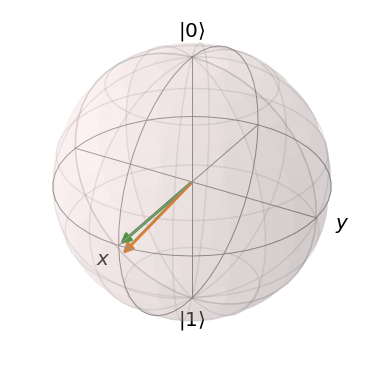

In [330]:
b1 = qt.Bloch()
b1.add_vectors([q1_evals[0][0], q1_evals[0][1], q1_evals[0][2]])
b1.add_vectors([q1_evals[-1][0], q1_evals[-1][1], q1_evals[-1][2]])
b1.show()

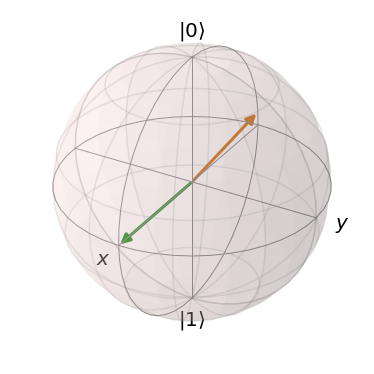

In [331]:
b2 = qt.Bloch()
b2.add_vectors([q2_evals[0][0], q2_evals[0][1], q2_evals[0][2]])
b2.add_vectors([q2_evals[-1][0], q2_evals[-1][1], q2_evals[-1][2]])
b2.show()